# (Kaggle PetFinder) Computer Vision: fine-tuning an image classifier 

## Imports

In [1]:
!pip install --upgrade pip -q
!pip install s3fs -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download en -q
!pip install catboost -q
!pip install opencv-python -q

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
/usr/local/lib/python3.6/site-packages/en_core_web_sm -->
/usr/local/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
%load_ext autoreload
%autoreload 2

from mxnet_utils import *
%matplotlib inline

## Preparing the `RecordIO` data

In [3]:
data = pd.read_csv('data.csv')
data.set_index('petid', inplace=True)
txt_feats = [c for c in data.columns if 'vec' in c]
cv_feats = [c for c in data.columns if 'cv' in c]
cols = [c for c in data.columns if c not in txt_feats+cv_feats]
data = data[cols]

In [4]:
data

,Unnamed: 0,Unnamed: 0.1,type,name,age,breed1,breed2,gender,color1,color2,...,state,rescuerid,videoamt,description,photoamt,adoptionspeed,score,magnitude,lang,len_desc
petid,,,,,,,,,,,,,,,,,,,,,
86e1089a3,0,0,2,Nibble,3,299,0,1,1,7,...,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2,0.3,2.4,en,77.0
6296e909a,1,1,2,No Name Yet,1,265,0,1,1,2,...,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0,-0.2,0.7,en,25.0
3422e4906,2,2,1,Brisco,1,307,0,1,2,7,...,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3,0.2,3.7,en,78.0
5842f1ff5,3,3,1,Miko,4,307,0,2,1,2,...,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2,0.9,0.9,en,32.0
850a43f90,4,4,1,Hunter,1,307,0,1,1,0,...,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2,0.6,3.7,en,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc0935a84,14988,14988,2,NaN,2,266,0,3,1,0,...,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,3.0,2,0.4,2.5,en,84.0
a01ab5b30,14989,14989,2,Serato & Eddie,60,265,264,3,1,4,...,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,3.0,4,0.0,0.3,en,37.0
d981b6395,14990,14990,2,Monkies,2,265,266,3,5,6,...,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",5.0,3,0.8,2.5,en,13.0


In [5]:
def get_image_names(row, fname_only=False):
    if int(row.photoamt)==0: return pd.DataFrame()
    if not fname_only: return pd.DataFrame([[row.name, row.adoptionspeed, f"./train_images/{row.name}-{i}.jpg"] for i in range(1, int(row.photoamt)+1)], columns=['petid', 'adoptionspeed', 'fname'])
    else: return pd.DataFrame([[row.name, row.adoptionspeed, f"{row.name}-{i}.jpg"] for i in range(1, int(row.photoamt)+1)], columns=['petid', 'adoptionspeed', 'fname'])

def save_lst(x, name, FOLDER="."):
    x.to_csv(os.path.join(FOLDER, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(FOLDER, 'temp.lst'), "rt") as fin:
        with open(os.path.join(FOLDER, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

In [13]:
artifacts = load_artifact('artifacts.pkl')
X_train = artifacts['X_train']
X_valid = artifacts['X_valid']

In [14]:
X_train.merge(X_valid, on='petid', how='inner').shape

(0, 1683)

In [15]:
get_image_names(data.loc['bf6ef8c07'], True)

,petid,adoptionspeed,fname
0,bf6ef8c07,3,bf6ef8c07-1.jpg
1,bf6ef8c07,3,bf6ef8c07-2.jpg
2,bf6ef8c07,3,bf6ef8c07-3.jpg
3,bf6ef8c07,3,bf6ef8c07-4.jpg
4,bf6ef8c07,3,bf6ef8c07-5.jpg


In [16]:
l = [get_image_names(row[1], True) for row in data.iterrows()]

In [17]:
df = pd.concat(l)

In [18]:
df_train = df.loc[df.petid.isin(X_train.petid)].reset_index(drop=True).reset_index()
df_valid = df.loc[df.petid.isin(X_valid.petid)].reset_index(drop=True).reset_index()

df_train.shape, df_valid.shape, len(df_valid)/(len(df_train)+len(df_valid))

((39002, 4), (19309, 4), 0.33113820719932774)

In [19]:
df_train.head()

,index,petid,adoptionspeed,fname
0,0,86e1089a3,2,86e1089a3-1.jpg
1,1,6296e909a,0,6296e909a-1.jpg
2,2,6296e909a,0,6296e909a-2.jpg
3,3,3422e4906,3,3422e4906-1.jpg
4,4,3422e4906,3,3422e4906-2.jpg


In [10]:
#df_train.sample(len(df_train)//4, random_state=0).adoptionspeed.value_counts()

In [11]:
#df_valid.sample(len(df_valid)//4, random_state=0).adoptionspeed.value_counts()

In [27]:
#save_lst(df_train[['index', 'adoptionspeed', 'fname']], 'train.lst')
#save_lst(df_valid[['index', 'adoptionspeed', 'fname']], 'valid.lst')

save_lst(df_valid.sample(len(df_valid)//4, random_state=0)[['index', 'adoptionspeed', 'fname']], 'valid_small.lst')
save_lst(df_train.sample(len(df_train)//4, random_state=0)[['index', 'adoptionspeed', 'fname']], 'train_small.lst')

In [5]:
!head train_small.lst

9384	3	3a050484c-10.jpg
4630	4	2831bd2b0-2.jpg
22520	1	a66c7ec50-2.jpg
21600	4	f15cd5cd9-4.jpg
19568	2	fbb8a0267-4.jpg
3147	1	fe3a83fe5-2.jpg
15339	2	799ea79a2-2.jpg
27121	1	1027c621c-1.jpg
30847	4	f64a1a0c4-3.jpg
8099	4	ce5bb821a-1.jpg


In [8]:
#mx.test_utils.get_im2rec_path()

In [3]:
#!python /usr/local/lib/python3.6/site-packages/mxnet/tools/im2rec.py train_small.lst train_images/

In [4]:
#!python /usr/local/lib/python3.6/site-packages/mxnet/tools/im2rec.py valid_small.lst train_images/

## Datasets and dataloaders

In [3]:
train_rec = 'train.rec'
valid_rec = 'valid.rec'
ctx = mx.gpu()

In [4]:
jitter_param = 0.4
lighting_param = 0.1

train_augs = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param, saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_augs = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

std_augs = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

In [5]:
train_imgs = gluon.data.vision.ImageRecordDataset(train_rec)
valid_imgs = gluon.data.vision.ImageRecordDataset(valid_rec)

In [6]:
train_iter = gluon.data.DataLoader(train_imgs.transform_first(train_augs), batch_size=64, shuffle=True)
valid_iter = gluon.data.DataLoader(valid_imgs.transform_first(valid_augs), batch_size=64)

In [7]:
X, y = next(iter(valid_iter))
X.shape, y.shape

((64, 3, 224, 224), (64,))

In [8]:
def show_batch(rec_file):
    dataset = gluon.data.vision.ImageRecordDataset(rec_file)
    loader = gluon.data.DataLoader(dataset.transform_first(std_augs), batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        labels = ['Same day', '1-7 days', '8-30 days', '31-90 days', 'No adop >100 days'][int(y[i].asnumpy()[0])]
        title = labels
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)).asnumpy())

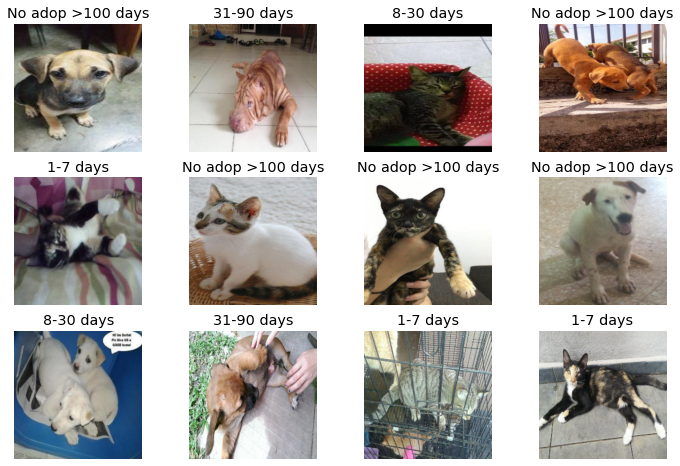

In [10]:
show_batch('valid.rec')

## Learning rate and momentum scheduling during training

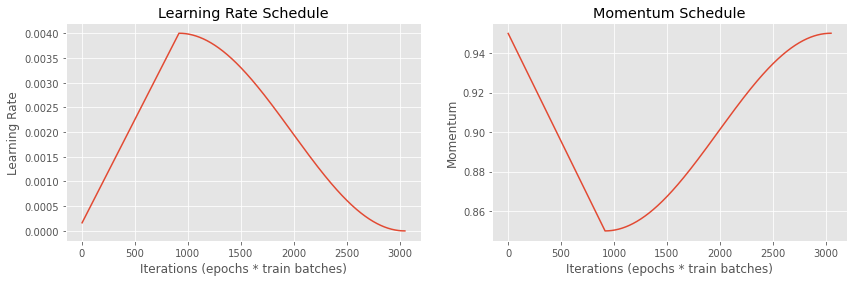

In [11]:
iterations, lr_schedule, mom_schedule = calc_lr_mom_schedule(5, len(train_iter), 4e-3)
hyper = {'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule}
plot_one_cycle_schedule(iterations, lr_schedule, mom_schedule)

## Learning rate finder

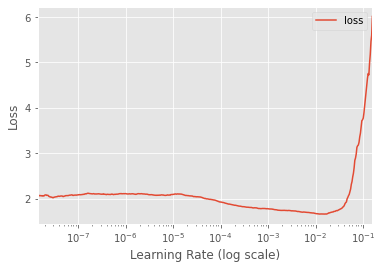

In [12]:
net = get_cnn('resnet18', ctx, classes=5)
df_lrs, min_grad_lr, min_grad_loss = find_lr(net=net, 
                                             dl=train_iter, 
                                             ctx=ctx,
                                             params=net.output.collect_params())

## Model training

In [13]:
# model = get_cnn('resnet18', ctx, classes=5)

# params = model.output.collect_params()
# trainer = gluon.Trainer(params, mx.optimizer.Adam(learning_rate=3e-4))
# model = train(train_iter, valid_iter, model, trainer, ctx, epochs=1)

In [ ]:
model = get_cnn('resnet18', ctx, classes=5)

epochs = 2
lr = 3e-4
_, lr_schedule, mom_schedule = calc_lr_mom_schedule(epochs, len(train_iter), lr)
model = fine_tune((train_iter, valid_iter), 
                  model,
                  lr=lr,
                  ctx=ctx,
                  epochs=epochs,
                  freeze=True,
                  hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule})

epochs = 5
_, lr_schedule, mom_schedule = calc_lr_mom_schedule(epochs, len(train_iter), lr/10)
model = fine_tune((train_iter, valid_iter), 
                  model,
                  lr=lr/10,
                  ctx=ctx,
                  epochs=epochs,
                  freeze=True,
                  hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule})

[Epoch 0] Train-acc: 0.26, loss: 1.722 | Val-acc: 0.283, loss: 1.585 | time: 6m:7s
[Epoch 1] Train-acc: 0.291, loss: 1.542 | Val-acc: 0.29, loss: 1.548 | time: 6m:5s
[Epoch 0] Train-acc: 0.29, loss: 1.527 | Val-acc: 0.287, loss: 1.547 | time: 6m:6s
[Epoch 1] Train-acc: 0.292, loss: 1.523 | Val-acc: 0.292, loss: 1.538 | time: 6m:5s


In [14]:
model = build_graph('resnet18', ctx=ctx)
model = train_fine_tuning(net=model, freeze=True, learning_rate=1e-4, num_epochs=2)
model = train_fine_tuning(net=model, freeze=False, learning_rate=1e-4/10, num_epochs=3)

[Epoch 0] Train-acc: 0.261, loss: 1.710 | Val-acc: 0.275, loss: 1.648 | time: 424.0
[Epoch 1] Train-acc: 0.276, loss: 1.594 | Val-acc: 0.286, loss: 1.580 | time: 424.3
[Epoch 0] Train-acc: 0.308, loss: 1.493 | Val-acc: 0.314, loss: 1.486 | time: 426.6
[Epoch 1] Train-acc: 0.336, loss: 1.432 | Val-acc: 0.317, loss: 1.467 | time: 426.3
[Epoch 2] Train-acc: 0.357, loss: 1.402 | Val-acc: 0.320, loss: 1.456 | time: 427.4


In [15]:
model.save_parameters('cv.params')

In [17]:
model = build_graph('resnet18', ctx=ctx)

iterations, lr_schedule, mom_schedule = calc_lr_mom_schedule(2, len(train_iter), 1e-4)
model = train_fine_tuning(net=model, freeze=True, learning_rate=1e-4, num_epochs=2, hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule})

iterations, lr_schedule, mom_schedule = calc_lr_mom_schedule(5, len(train_iter), 1e-4/10)
model = train_fine_tuning(net=model, freeze=False, learning_rate=1e-4/10, num_epochs=5, hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule})

[Epoch 0] Train-acc: 0.243, loss: 1.831 | Val-acc: 0.262, loss: 1.690 | time: 423.6
[Epoch 1] Train-acc: 0.271, loss: 1.646 | Val-acc: 0.271, loss: 1.652 | time: 424.2
[Epoch 0] Train-acc: 0.282, loss: 1.579 | Val-acc: 0.298, loss: 1.550 | time: 427.7
[Epoch 1] Train-acc: 0.315, loss: 1.484 | Val-acc: 0.313, loss: 1.496 | time: 434.1
[Epoch 2] Train-acc: 0.338, loss: 1.432 | Val-acc: 0.317, loss: 1.475 | time: 433.7
[Epoch 3] Train-acc: 0.351, loss: 1.409 | Val-acc: 0.318, loss: 1.466 | time: 433.2
[Epoch 4] Train-acc: 0.358, loss: 1.395 | Val-acc: 0.321, loss: 1.466 | time: 433.1


In [18]:
model.save_parameters('cv_schedule.params')

## Using the trained model as an image feature extractor

In [59]:
def get_names(row):
    if int(row.photoamt)==0: return []
    return [f"./train_images/{row.name}-{i}.jpg" for i in range(1, int(row.photoamt)+1)]

def extract_image_feats(fn):
    img = mx.image.imread(fn)
    transformed_img = valid_augs(img)[None]
    return model.features(transformed_img).squeeze()

def images_features(row):
    fnames = get_names(row)
    if len(fnames)==0: return np.zeros(512).tolist()
    feats = [extract_image_feats(fn).asnumpy() for fn in fnames]
    return np.stack(feats).mean(axis=0).tolist()

In [47]:
model = build_graph('resnet18', ctx=mx.cpu())
model.load_parameters('cv.params', ctx=mx.cpu())

In [61]:
get_names(data.loc['bb928145e'])

['./train_images/bb928145e-1.jpg',
 './train_images/bb928145e-2.jpg',
 './train_images/bb928145e-3.jpg']

In [63]:
len(images_features(data.loc['bb928145e']))

512

In [70]:
cv = data[['photoamt']].copy()
cv[[f"cv_{i}" for i in range(512)]] = cv.apply(lambda row: images_features(row), axis='columns', result_type='expand')

In [71]:
cv

,photoamt,cv_0,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,...,cv_502,cv_503,cv_504,cv_505,cv_506,cv_507,cv_508,cv_509,cv_510,cv_511
petid,,,,,,,,,,,,,,,,,,,,,
86e1089a3,1.0,0.078874,0.816358,0.244287,0.208906,1.349789,2.502053,0.055648,0.941013,0.326408,...,0.952883,0.404647,0.673428,1.209803,1.356111,0.365537,0.183584,1.631660,0.589854,1.611040
6296e909a,2.0,0.339655,0.319573,0.916502,0.184687,0.180510,1.852308,0.276001,0.263027,0.437963,...,2.163117,0.636680,0.865185,0.106698,0.826329,0.026099,0.476873,2.909973,0.836300,1.731637
3422e4906,7.0,1.832132,0.447524,0.591078,1.131541,0.774884,0.302708,1.094931,0.500808,0.535459,...,0.495101,0.446511,1.726960,0.360765,1.104598,0.885743,0.619196,1.051355,1.136124,0.289299
5842f1ff5,8.0,1.059458,0.479126,0.819754,1.461157,0.525102,0.310538,0.613492,0.775307,0.543174,...,0.844050,0.568782,0.271734,0.674273,0.881705,0.513027,0.141386,0.903686,1.138879,1.025745
850a43f90,3.0,1.218860,0.513823,1.940016,1.311631,1.022913,1.075007,1.639609,0.136224,0.183552,...,0.592788,0.048249,1.091958,0.047421,0.927461,0.230027,0.022744,0.607129,1.086601,1.053505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc0935a84,3.0,0.569441,0.390044,1.059398,0.303033,1.585878,0.804970,1.752187,1.691950,1.046866,...,0.895144,0.120644,0.993073,0.406253,1.535856,0.488523,0.173545,0.253545,0.600014,0.383081
a01ab5b30,3.0,0.162366,1.086958,0.340885,1.153609,0.793956,1.584493,0.505177,0.911743,1.126595,...,0.947087,0.650084,0.767311,0.949631,0.965372,1.018490,1.048009,1.632179,0.426780,0.843686
d981b6395,5.0,0.165288,0.872090,0.137330,0.592846,0.684375,1.055347,1.296673,0.646296,0.717880,...,1.039180,2.353233,0.911277,0.589992,1.387031,1.507881,0.292630,0.935020,0.556880,1.469102


In [73]:
cv.to_csv('cv.csv')